In [1]:
%pylab inline
from skreducedmodel.reducedbasis import ReducedBasis
from skreducedmodel.empiricalinterpolation import EmpiricalInterpolation
from skreducedmodel.surrogate import Surrogate
from skreducedmodel.mksurrogate import mksurrogate

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
from scipy.integrate import odeint

def pend(y, t, b, λ):
    θ, ω = y
    dydt = [ω, -b*ω - λ*np.sin(θ)]

    return dydt

# set friction strength
b = 0.2
# set initial conditions
y0 = [np.pi/2, 0.]

times = np.linspace(0,50,1001)
λ = 1.
sol = odeint(pend,y0, times, (b,λ))

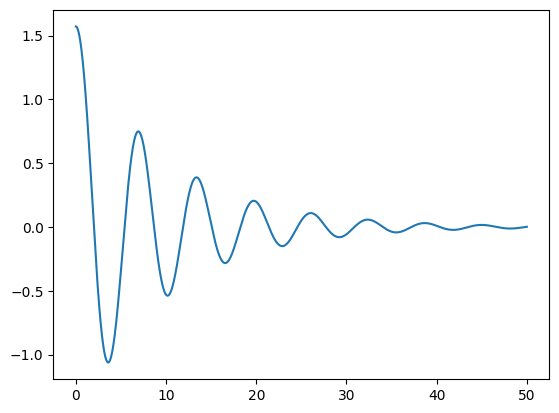

In [3]:
plt.plot(times, sol[:,0])

In [4]:
param = np.linspace(1,5,101)
training = []
for λ in param:
    sol = odeint(pend,y0, times, (b,λ))
    training.append(sol[:,0])

In [4]:
param

array([1.  , 1.04, 1.08, 1.12, 1.16, 1.2 , 1.24, 1.28, 1.32, 1.36, 1.4 ,
       1.44, 1.48, 1.52, 1.56, 1.6 , 1.64, 1.68, 1.72, 1.76, 1.8 , 1.84,
       1.88, 1.92, 1.96, 2.  , 2.04, 2.08, 2.12, 2.16, 2.2 , 2.24, 2.28,
       2.32, 2.36, 2.4 , 2.44, 2.48, 2.52, 2.56, 2.6 , 2.64, 2.68, 2.72,
       2.76, 2.8 , 2.84, 2.88, 2.92, 2.96, 3.  , 3.04, 3.08, 3.12, 3.16,
       3.2 , 3.24, 3.28, 3.32, 3.36, 3.4 , 3.44, 3.48, 3.52, 3.56, 3.6 ,
       3.64, 3.68, 3.72, 3.76, 3.8 , 3.84, 3.88, 3.92, 3.96, 4.  , 4.04,
       4.08, 4.12, 4.16, 4.2 , 4.24, 4.28, 4.32, 4.36, 4.4 , 4.44, 4.48,
       4.52, 4.56, 4.6 , 4.64, 4.68, 4.72, 4.76, 4.8 , 4.84, 4.88, 4.92,
       4.96, 5.  ])

In [5]:
q_ej = 2.94

sol_test = odeint(pend,y0, times, (b,q_ej))
h = sol_test[:,0]

In [6]:
rb = ReducedBasis(greedy_tol = 1e-16,
                  lmax = 2, 
                  nmax = 10)

rb.fit(training_set = np.array(training),
       parameters = param,
       physical_points = times
       )
# q necesario para caso con particion
wave_rb = rb.transform(h,q_ej)

In [7]:
from anytree import RenderTree

def visual_tree(tree):
    for pre, fill, node in RenderTree(tree):
        print("%s%s" % (pre, node.name))

visual_tree(rb.tree)

(0,)
├── (0, 0)
│   ├── (0, 0, 0)
│   └── (0, 0, 1)
└── (0, 1)
    ├── (0, 1, 0)
    └── (0, 1, 1)


In [8]:
eim = EmpiricalInterpolation(rb)
eim.fit()
# q necesario para caso con particion
wave_eim = eim.transform(h,q_ej)

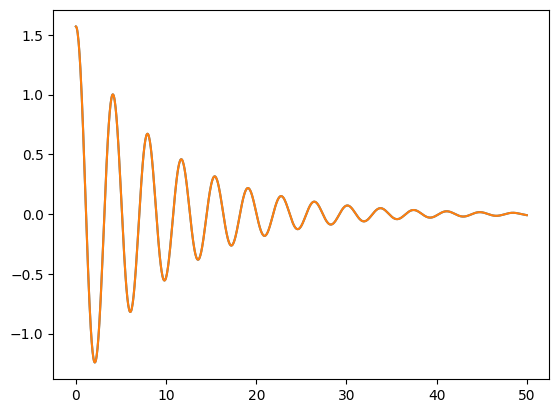

In [9]:
plt.plot(times,wave_eim)
plt.plot(times, h)

In [10]:
#q = 1.14
surrogate = Surrogate(eim, poly_deg = 3)
surrogate.fit()
wave_surr = surrogate.predict(q_ej)

Text(0.5, 0, '$\\rm time$')

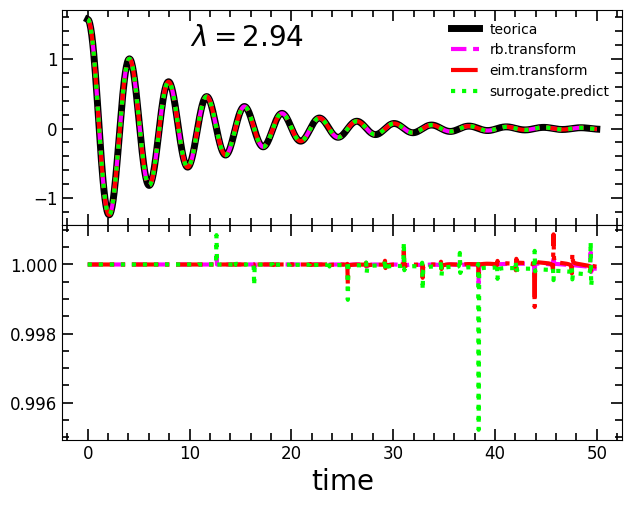

In [11]:
#λ = 1.14
sol_test = odeint(pend,y0, times, (b,q_ej))
h = sol_test[:,0]

color_rb = 'magenta'
color_eim = 'red'
color_surr = 'lime'

fig, axs = plt.subplots(2, 1,figsize=(7,5),sharex=True,sharey=False,)
fig.subplots_adjust(hspace=0.0,wspace=0.0,bottom=0.12, top=0.98, left=0.17, right=0.97)

axs[0].plot(times, h, color='black',lw=5,label='teorica')

axs[0].plot(times,wave_rb, ls='--',label='rb.transform',lw=3,color=color_rb)
axs[0].plot(times,wave_eim, ls='-.',label='eim.transform',lw=3,color=color_eim)
axs[0].plot(times,wave_surr, ls='dotted',label='surrogate.predict',lw=3,color=color_surr)

axs[0].legend(frameon=False)

axs[0].tick_params('both',length=5,width=1.2,which='minor',direction='in',right='on',top='on')
axs[0].tick_params('both',length=8,width=1.2,which='major',direction='in',right='on',top='on')
axs[0].tick_params(labelsize=12)
axs[0].minorticks_on()
axs[0].text(10,1.2,'$\\lambda = 2.94$',size=20)


axs[1].plot(times,wave_rb/h, ls='--',label='rb.transform',lw=3,color=color_rb)
axs[1].plot(times,wave_eim/h, ls='-.',label='eim.transform',lw=3,color=color_eim)
axs[1].plot(times,wave_surr/h, ls='dotted',label='surrogate.predict',lw=3,color=color_surr)
#axs[1].legend()
axs[1].tick_params('both',length=5,width=1.2,which='minor',direction='in',right='on',top='on')
axs[1].tick_params('both',length=8,width=1.2,which='major',direction='in',right='on',top='on')
axs[1].tick_params(labelsize=12)
axs[1].minorticks_on()
#axs[1].semilogy()

axs[1].set_xlabel('$\\rm time$',size=20)

In [12]:
from skreducedmodel.reducedbasis import normalize_set, error
params = np.linspace(1.01,4.99,301)

# calculamos soluciones teoricas
h_test = []
for q in params:
    sol_test = odeint(pend,y0, times, (b,q))
    h_test.append(sol_test[:,0])

# Normalizamos las ondas
#h_test_normalized = normalize_set(h_test, times)
    
# calculamos proyecciones y prediccion para surrogate

rb_ts = []
eim_ts = []
surr_ts = []

for wave, q in zip(h_test, params):
    rb_ts.append(rb.transform(wave,q))
    eim_ts.append(eim.transform(wave,q))
    surr_ts.append(surrogate.predict(q))

rb_ts = np.array(rb_ts)
eim_ts = np.array(eim_ts)
surr_ts = np.array(surr_ts)

# calculamos los errores para las proyecciones y prediccion
errors_rb = []
errors_eim = []
errors_surr = []
for i in range(len(params)):
    errors_rb.append(error(h_test[i], rb_ts[i], times))
    errors_eim.append(error(h_test[i], eim_ts[i], times))
    errors_surr.append(error(h_test[i], surr_ts[i], times))

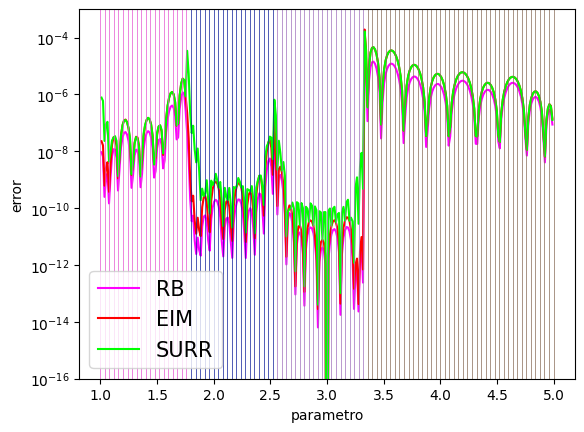

In [13]:
plt.plot(params,errors_rb,label='RB',color=color_rb)
plt.plot(params,errors_eim,label='EIM',color=color_eim)
plt.plot(params,errors_surr,label='SURR',color=color_surr)#,marker='o')
plt.xlabel('parametro')
plt.ylabel('error')
plt.semilogy()
plt.legend(frameon=True,fontsize=15)

np.random.seed(seed=6)
plt.ylim(1e-16,1e-3)
#plt.yticks([])

for leaf in rb.tree.leaves:
    color = np.random.rand(3,)
    for p in leaf.train_parameters[:]:
        plt.axvline(p,c=color,lw=.5)

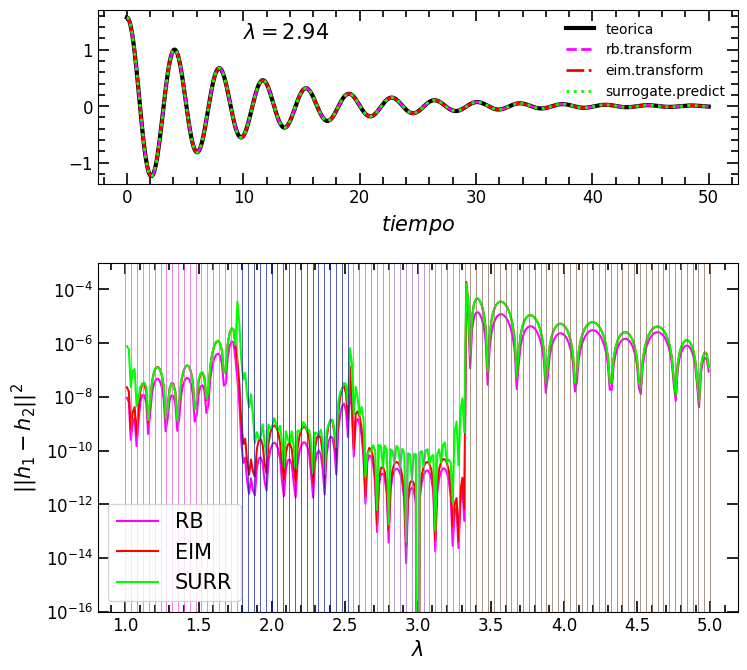

In [19]:
#λ = 1.14
sol_test = odeint(pend,y0, times, (b,q_ej))
h = sol_test[:,0]

color_rb = 'magenta'
color_eim = 'red'
color_surr = 'lime'

fig, axs = plt.subplots(2, 1,figsize=(8,7),sharex=False,sharey=False,gridspec_kw={'height_ratios': [1, 2]})
fig.subplots_adjust(hspace=0.3,wspace=0,bottom=0.12, top=0.98, left=0.17, right=0.97)

axs[0].plot(times, h, color='black',lw=3,label='teorica')

axs[0].plot(times,wave_rb, ls='--',label='rb.transform',lw=2,color=color_rb)
axs[0].plot(times,wave_eim, ls='-.',label='eim.transform',lw=2,color=color_eim)
axs[0].plot(times,wave_surr, ls='dotted',label='surrogate.predict',lw=2,color=color_surr)

axs[0].legend(frameon=False,loc='upper right')

axs[0].tick_params('both',length=5,width=1.2,which='minor',direction='in',right='on',top='on')
axs[0].tick_params('both',length=8,width=1.2,which='major',direction='in',right='on',top='on')
axs[0].tick_params(labelsize=12)
axs[0].minorticks_on()
axs[0].text(10,1.2,'$\\lambda = 2.94$',size=15)
axs[0].set_xlabel('$ tiempo$',size=15)

axs[1].plot(params,errors_rb,label='RB',color=color_rb)
axs[1].plot(params,errors_eim,label='EIM',color=color_eim)
axs[1].plot(params,errors_surr,label='SURR',color=color_surr)#,marker='o')
axs[1].set_xlabel('$\lambda$',size=15)
axs[1].set_ylabel('$||h_1 - h_2||^{2}$',size=15)
axs[1].semilogy()
axs[1].legend(frameon=True,fontsize=15)

np.random.seed(seed=6)
axs[1].set_ylim(1e-16,1e-3)
#plt.yticks([])

for leaf in rb.tree.leaves:
    color = np.random.rand(3,)
    for p in leaf.train_parameters[:]:
        axs[1].axvline(p,c=color,lw=.5)
#axs[1].semilogy()

axs[1].set_xlabel('$\lambda$',size=15)

axs[1].tick_params('both',length=5,width=1.2,which='minor',direction='in',right='on',top='on')
axs[1].tick_params('both',length=8,width=1.2,which='major',direction='in',right='on',top='on')
axs[1].tick_params(labelsize=12)
axs[1].minorticks_on()

#plt.savefig(fname='../fig_ejemplo.pdf',format='pdf') 

In [32]:
q

4.99